In [1]:
import pandas as pd
from datasets import load_from_disk
from collections import Counter
import matplotlib.pyplot as plt

### Loading Dataset: Train, Val, Test ###

In [4]:
# https://stackoverflow.com/questions/2352181/how-to-use-a-dot-to-access-members-of-dictionary
class dotdict(dict):
    """dot.notation access to dictionary attributes, as dict.key_name, not as dict["key_name"] """
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__


In [16]:
import yaml

# Read config.yaml file
with open("config.yaml") as infile:
    SAVED_CFG = yaml.load(infile, Loader=yaml.FullLoader)
    SAVED_CFG = dotdict(SAVED_CFG)

# arguments setting
data_args = dotdict(SAVED_CFG.data)
model_args = dotdict(SAVED_CFG.custom_model)

dataset = load_from_disk(data_args.dataset_name)
### Includes Train & Validation data ###

test_dataset = load_from_disk(data_args.test_dataset_name)

In [17]:
dataset

DatasetDict({
    train: Dataset({
        features: ['__index_level_0__', 'answers', 'context', 'document_id', 'id', 'question', 'title'],
        num_rows: 3952
    })
    validation: Dataset({
        features: ['__index_level_0__', 'answers', 'context', 'document_id', 'id', 'question', 'title'],
        num_rows: 240
    })
})

In [18]:
dataset['train'][0]

{'title': '미국 상원',
 'context': '미국 상의원 또는 미국 상원(United States Senate)은 양원제인 미국 의회의 상원이다.\\n\\n미국 부통령이 상원의장이 된다. 각 주당 2명의 상원의원이 선출되어 100명의 상원의원으로 구성되어 있다. 임기는 6년이며, 2년마다 50개주 중 1/3씩 상원의원을 새로 선출하여 연방에 보낸다.\\n\\n미국 상원은 미국 하원과는 다르게 미국 대통령을 수반으로 하는 미국 연방 행정부에 각종 동의를 하는 기관이다. 하원이 세금과 경제에 대한 권한, 대통령을 포함한 대다수의 공무원을 파면할 권한을 갖고 있는 국민을 대표하는 기관인 반면 상원은 미국의 주를 대표한다. 즉 캘리포니아주, 일리노이주 같이 주 정부와 주 의회를 대표하는 기관이다. 그로 인하여 군대의 파병, 관료의 임명에 대한 동의, 외국 조약에 대한 승인 등 신속을 요하는 권한은 모두 상원에게만 있다. 그리고 하원에 대한 견제 역할(하원의 법안을 거부할 권한 등)을 담당한다. 2년의 임기로 인하여 급진적일 수밖에 없는 하원은 지나치게 급진적인 법안을 만들기 쉽다. 대표적인 예로 건강보험 개혁 당시 하원이 미국 연방 행정부에게 퍼블릭 옵션(공공건강보험기관)의 조항이 있는 반면 상원의 경우 하원안이 지나치게 세금이 많이 든다는 이유로 퍼블릭 옵션 조항을 제외하고 비영리건강보험기관이나 보험회사가 담당하도록 한 것이다. 이 경우처럼 상원은 하원이나 내각책임제가 빠지기 쉬운 국가들의 국회처럼 걸핏하면 발생하는 의회의 비정상적인 사태를 방지하는 기관이다. 상원은 급박한 처리사항의 경우가 아니면 법안을 먼저 내는 경우가 드물고 하원이 만든 법안을 수정하여 다시 하원에 되돌려보낸다. 이러한 방식으로 단원제가 빠지기 쉬운 함정을 미리 방지하는 것이다.날짜=2017-02-05',
 'question': '대통령을 포함한 미국의 행정부 견제권을 갖는 국가 기관은?',
 'id': 'mrc-1-000067',
 'answers': {'answer_start'

#### Converting to Pandas Dataframe for convenient analysis

In [21]:
def pull_out_dictionary(df_input: pd.DataFrame):
    """pull out str `{}` values from the pandas dataframe and shape it as a new column"""

    df = df_input.copy()

    # assign subject_entity and object_entity column values type as dictionary
    # df["answers"] = df["answers"].apply(lambda x: eval(x))
    
    df = df.assign(
        # subject_entity
        answer_start=lambda x: x["answers"].apply(lambda x: x["answer_start"]),
        text=lambda x: x["answers"].apply(lambda x: x["text"]),
    )

    # drop subject_entity and object_entity column
    df = df.drop(["answers"], axis=1)

    return df


In [26]:
### Converting to Pandas dataframe for convenient analysis ###
train_df = pull_out_dictionary(pd.DataFrame.from_records(dataset['train']))
val_df = pull_out_dictionary(pd.DataFrame.from_records(dataset['validation']))
test_df = pd.DataFrame.from_records(test_dataset['validation'])

In [27]:
### Train DF ###
train_df.head()

,title,context,question,id,document_id,__index_level_0__,answer_start,text
0,미국 상원,미국 상의원 또는 미국 상원(United States Senate)은 양원제인 미국...,대통령을 포함한 미국의 행정부 견제권을 갖는 국가 기관은?,mrc-1-000067,18293,42,[235],[하원]
1,인사조직관리,'근대적 경영학' 또는 '고전적 경영학'에서 현대적 경영학으로 전환되는 시기는 19...,현대적 인사조직관리의 시발점이 된 책은?,mrc-0-004397,51638,2873,[212],[《경영의 실제》]
2,강희제,강희제는 강화된 황권으로 거의 황제 중심의 독단적으로 나라를 이끌어 갔기에 자칫 전...,강희제가 1717년에 쓴 글은 누구를 위해 쓰여졌는가?,mrc-1-000362,5028,230,[510],[백성]
3,금동삼존불감,"불상을 모시기 위해 나무나 돌, 쇠 등을 깎아 일반적인 건축물보다 작은 규모로 만든...",11~12세기에 제작된 본존불은 보통 어떤 나라의 특징이 전파되었나요?,mrc-0-001510,34146,992,[625],[중국]
4,계사명 사리구,동아대학교박물관에서 소장하고 있는 계사명 사리구는 총 4개의 용기로 구성된 조선후기...,명문이 적힌 유물을 구성하는 그릇의 총 개수는?,mrc-0-000823,47334,548,[30],[4개]


In [28]:
### VAL DF ###
val_df.head()

,title,context,question,id,document_id,__index_level_0__,answer_start,text
0,전효숙,"순천여자고등학교 졸업, 1973년 이화여자대학교를 졸업하고 1975년 제17회 사법...",처음으로 부실 경영인에 대한 보상 선고를 받은 회사는?,mrc-0-003264,9027,2146,[284],[한보철강]
1,스토우빌선,요크 카운티 동쪽에 처음으로 여객 열차 운행이 시작한 시점은 1868년 토론토 & ...,스카버러 남쪽과 코보콘그 마을의 철도 노선이 처음 연장된 연도는?,mrc-0-004762,51765,3106,[146],[1871년]
2,촐라,"촐라 정부\n 촐라의 정부 체제는 전제군주제였으며,2001 촐라의 군주는 절대적인 ...",촌락에서 운영 위원 후보자 이름을 쓰기위해 사용된 것은?,mrc-1-001810,15694,1180,[517],[나뭇잎]
3,백조 기사,프랑스의 십자군 무훈시는 1099년 예루살렘 왕국의 통치자가 된 고드프루아 드 부용...,로타이르가 백조를 구하기 위해 사용한 것은?,mrc-1-000219,59536,141,[1109],[금대야]
4,탈관료제화,탈관료제화는 현대사회에서 관료제 성격이 약화되는 현상이다. 현대사회에서 관료제는 약...,의견을 자유롭게 나누는 것은 조직 내 어떤 관계에서 가능한가?,mrc-1-000285,32991,184,[386],[수평적 관계]


In [29]:
### TEST DF ###
test_df.head()

,question,id
0,유령'은 어느 행성에서 지구로 왔는가?,mrc-1-000653
1,용병회사의 경기가 좋아진 것은 무엇이 끝난 이후부터인가?,mrc-1-001113
2,돌푸스에게 불특정 기간동안 하원이 잠시 쉬는 것을 건의 받았던 인물은?,mrc-0-002191
3,"마오리언어와 영어, 뉴질랜드 수화를 공식 언어로 사용하는 나라는?",mrc-0-003951
4,디엔비엔푸 전투에서 보응우옌잡이 상대한 국가는?,mrc-1-001272


In [30]:
print(f"Train Data Size: {len(train_df)}")
print(f"Validation Data Size: {len(val_df)}")
print(f"Test Data Size: {len(test_df)}")

Train Data Size: 3952
Validation Data Size: 240
Test Data Size: 600


In [33]:
# check if there is only one value at lists inside of the column
train_df.answer_start.apply(lambda x: len(x)).value_counts() == len(train_df)

1    True
Name: answer_start, dtype: bool

In [34]:
train_df.text.apply(lambda x: len(x)).value_counts() == len(train_df)

1    True
Name: text, dtype: bool

#### Analysis for 'answers' column

In [11]:
### Answer word count ###

In [12]:
### Extracting only the 'text' parts from answers column ###
answer_texts = [train_df.iloc[i]['answers']['text'] for i in range(len(train_df))]

In [13]:
answer_texts[:10]

[['하원'],
 ['《경영의 실제》'],
 ['백성'],
 ['중국'],
 ['4개'],
 ['드래곤'],
 ['형양태수 왕식'],
 ['이탈리아군'],
 ['큰아들 유'],
 ['왕대마을']]

In [14]:
### Checking the length of answer texts splitted with space ' ' ###
answer_text_lengths = [len(i[0].split()) for i in answer_texts]

In [15]:
answer_text_lengths[:20]

[1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 2]

In [16]:
number_of_answers = [len(i) for i in answer_texts]

In [17]:
Counter(number_of_answers)

Counter({1: 3952})

In [18]:
word_counts = Counter(answer_text_lengths)

In [19]:
word_counts

Counter({1: 2288,
         2: 1065,
         3: 349,
         5: 52,
         8: 7,
         6: 39,
         4: 120,
         7: 18,
         15: 1,
         9: 4,
         13: 1,
         20: 1,
         10: 3,
         14: 2,
         18: 1,
         16: 1})

In [20]:
counts = sorted([key for key,value in word_counts.items()])
freq = [word_counts[count] for count in counts]

In [21]:
counts

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 14, 15, 16, 18, 20]

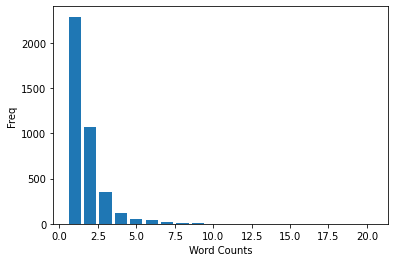

In [22]:
plt.bar(counts, freq, align = 'center')
plt.xlabel('Word Counts')
plt.ylabel('Freq')
plt.show()